In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [2]:
train = pd.read_csv('../data/assignment_2_train.csv')

test = pd.read_csv('../data/assignment_2_test.csv')

In [3]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']
print("data.shape = {} rows, {} cols".format(*X.shape))

data.shape = 180000 rows, 393 cols


In [5]:
X_leader_board = test.drop(['isFraud'], axis=1)
y_leader_board = test['isFraud']
print("data.shape = {} rows, {} cols".format(*test.shape))

data.shape = 100001 rows, 394 cols


In [6]:
def feature_selector(X):
    numerical_features = X.select_dtypes(include=[np.number])
    numerical_features = numerical_features.columns.tolist()
    
    cat_features = X.select_dtypes(include=[np.object])
    cat_features = cat_features.columns.tolist()
    
    dummies_features = pd.get_dummies(X[cat_features])
    X = pd.concat([X, dummies_features], axis=1)
    dummies_features = dummies_features.columns.tolist()
    X = X.drop(cat_features, axis=1)
    return X

In [7]:
def train_test_split_by_quantile(X,y, quantile):
    indx = X["TransactionID"].quantile(quantile).round().astype(int)
    x_train = X[X["TransactionID"] <= indx]
    x_test = X[X["TransactionID"] > indx]
    y_train = y[:len(x_train)]
    y_test = y[len(x_train):]
    
    return x_train, x_test, y_train, y_test

In [8]:
def create_bootstrap_samples(data: np.array, n_samples: int = 2000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound


In [9]:
X = feature_selector(X)
X_leader_board = feature_selector(X_leader_board)

In [10]:
drop_features = list(set(X) - set(X_leader_board))
X = X.drop(drop_features, axis=1)

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split_by_quantile(X, y, 0.75)

In [12]:
print(f"Размерности x_train {x_train.shape}")
print(f"Размерности y_train {y_train.shape}")
print(f"Размерности x_valid {x_valid.shape}")
print(f"Размерности y_valid {y_valid.shape}")
print(f"Размерности x_leader_board {X_leader_board.shape}")
print(f"Размерности y_leader_board {y_leader_board.shape}")

Размерности x_train (135000, 526)
Размерности y_train (135000,)
Размерности x_valid (45000, 526)
Размерности y_valid (45000,)
Размерности x_leader_board (100001, 526)
Размерности y_leader_board (100001,)


Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [13]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves":20,
    "lambda_l2":400,
    "learning_rate": 0.2,
    "n_estimators": 300,
    "n_jobs": -1,
    "seed": 27
}

In [14]:
%%time
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=200
)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3441, number of negative: 131559
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32043
[LightGBM] [Info] Number of data points in the train set: 135000, number of used features: 498
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025489 -> initscore=-3.643693
[LightGBM] [Info] Start training from score -3.643693
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.946481	valid_1's auc: 0.900623
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.956366	valid_1's auc: 0.903935
CPU times: user 2min 40s, sys: 3.73 s, total: 2min 44s
Wa

In [15]:
train_score = roc_auc_score(y_train, model.predict(x_train))
valid_score = roc_auc_score(y_valid, model.predict(x_valid))
leader_board = roc_auc_score(y_leader_board, model.predict(X_leader_board))

print(f"Train-score: {round(train_score, 3)}, Validation-score: {round(valid_score, 3)}, Leader_board-score: {round(leader_board, 3)}")

Train-score: 0.956, Validation-score: 0.904, Leader_board-score: 0.867


Вывод: Результат на трейне очень похож на переобучение , нужно увеличить регуляцию. Результаты на валидационной и тестовой скорее всего отличаются тем что в них разные распределения признаков. Об этом говорит то что при dummie кодировании размерность не совпадала и в тестовых данных признаке R_emaildomain имелись значения которых не было в трейне.

Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [16]:
x_train, x_test, y_train, y_test = train_test_split_by_quantile(X, y, 0.70)
x_valid, x_test, y_valid, y_test = train_test_split_by_quantile(x_test, y_test, 0.70)
print(f"Размерности x_train {x_train.shape}")
print(f"Размерности y_train {y_train.shape}")
print(f"Размерности x_valid {x_valid.shape}")
print(f"Размерности y_valid {y_valid.shape}")
print(f"Размерности x_test {x_test.shape}")
print(f"Размерности y_test {y_test.shape}")
print(f"Размерности x_leader_board {X_leader_board.shape}")
print(f"Размерности y_leader_board {y_leader_board.shape}")

Размерности x_train (126000, 526)
Размерности y_train (126000,)
Размерности x_valid (37800, 526)
Размерности y_valid (37800,)
Размерности x_test (16200, 526)
Размерности y_test (16200,)
Размерности x_leader_board (100001, 526)
Размерности y_leader_board (100001,)


In [17]:
%%time
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=200
)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3096, number of negative: 122904
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31845
[LightGBM] [Info] Number of data points in the train set: 126000, number of used features: 495
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024571 -> initscore=-3.681293
[LightGBM] [Info] Start training from score -3.681293
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.945638	valid_1's auc: 0.905364
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.956304	valid_1's auc: 0.908129
CPU times: user 2min 25s, sys: 3.58 s, total: 2min 28s
Wa

In [18]:
train_score = roc_auc_score(y_train, model.predict(x_train))
valid_score = roc_auc_score(y_valid, model.predict(x_valid))
test_score = roc_auc_score(y_test, model.predict(x_test))
leader_board = roc_auc_score(y_leader_board, model.predict(X_leader_board))

print(f"Train-score: {round(train_score, 3)}, Validation-score: {round(valid_score, 3)}, test_score-score: {round(test_score, 3)} , Leader_board-score: {round(leader_board, 3)}")

Train-score: 0.956, Validation-score: 0.908, test_score-score: 0.891 , Leader_board-score: 0.869


Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [19]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(x_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.8754786104607368, 0.9050806535981787)

Text(0.5, 0, 'sample number')

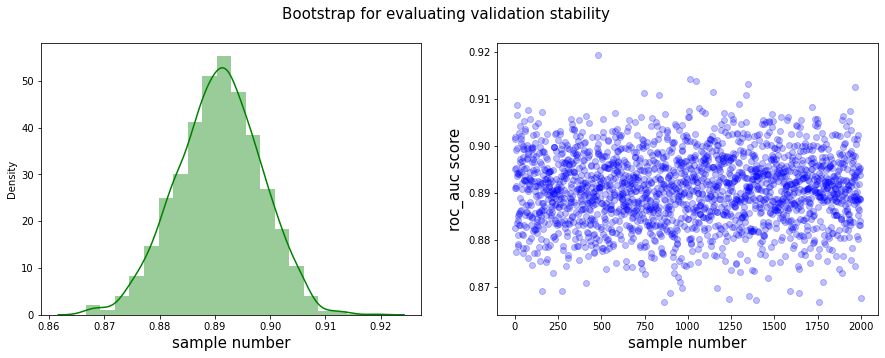

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("roc_auc score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

Вывод : значение метрики на лидерборде меньше нижнего порога доверительного интервала. Это говорит о том что распределение признаков разное 

Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из
assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [21]:
X_adv = pd.concat([
    x_train, X_leader_board
])
y_adv = np.hstack(
    (np.ones(x_train.shape[0]), np.zeros(X_leader_board.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [22]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": -1}
model_xgb = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model_xgb,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

[21:07:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:07:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:07:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-score: 1.0
CPU times: user 3min 7s, sys: 1.95 s, total: 3min 9s
Wall time: 19.1 s


[21:07:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs leaderboard)')

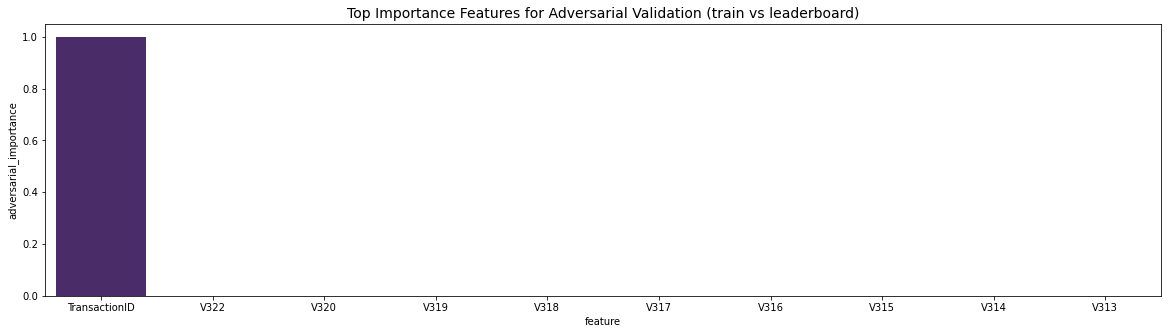

In [23]:
model_xgb.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model_xgb.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs leaderboard)", size=14)

Распределения в выборках разные, модель не может разделить данные поэтому  roc_auc = 1

Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [27]:
%%time
cv_lgbm = cross_val_score(
    estimator=lgb.LGBMClassifier(**params), X=X, y=y, scoring="roc_auc", cv=5
)
print(cv_lgbm)
print(f"CV-mean: {round(np.mean(cv_lgbm), 4)}, CV-std: {round(np.std(cv_lgbm), 4)}")

[LightGBM] [Warning] lambda_l2 is set=400, reg_lambda=0.0 will be ignored. Current value: lambda_l2=400
[LightGBM] [Warning] lambda_l2 is set=400, reg_lambda=0.0 will be ignored. Current value: lambda_l2=400
[LightGBM] [Warning] lambda_l2 is set=400, reg_lambda=0.0 will be ignored. Current value: lambda_l2=400
[LightGBM] [Warning] lambda_l2 is set=400, reg_lambda=0.0 will be ignored. Current value: lambda_l2=400
[LightGBM] [Warning] lambda_l2 is set=400, reg_lambda=0.0 will be ignored. Current value: lambda_l2=400
[0.90308956 0.91403562 0.79152915 0.76481922 0.89702472]
CV-mean: 0.8541, CV-std: 0.0628
CPU times: user 11min 16s, sys: 14.4 s, total: 11min 31s
Wall time: 1min 4s


Вывод : разброс очень большой, кросс-валидация не устойчивая. 